# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

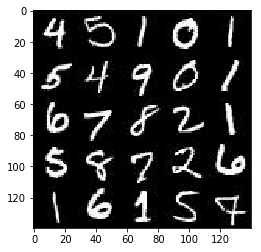

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

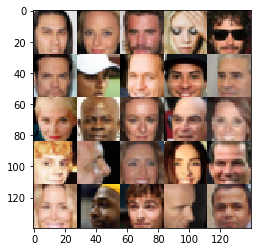

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [37]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # Define model inputs: let's keep the good practice of naming vars.
    image_shape = (None, image_width, image_height, image_channels)
    real_images_stream = tf.placeholder(tf.float32, image_shape, name='input_real_stream')
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='input_random_stream')
    learning_rate = tf.placeholder(tf.float32, name='lrate')
    return (real_images_stream, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Let's define our discriminator or "inspector agent".
    # Extremely inspired on Mat's implementation!
    with tf.variable_scope('discriminator', reuse=reuse):
        # Our images are really low resolution: 28x28x3
        # We do not have branches (not inceptioned) so will keep the whole model in a 
        # single variable called "net".
        
        # First layer (BatchNorm avoided).
        # 2D conv.
        net = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        # Leaky relu.
        net = tf.maximum(0.1*net, net)
        
        # Second layer.
        net = tf.layers.conv2d(net, 128, 5, strides=2, padding='same')
        # BatchNorm (It is awesome how tf.layers provides the user this high level abstractions)
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(0.1*net, net)
        
        # Third layer.
        net = tf.layers.conv2d(net, 256, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=True)
        net = tf.maximum(0.1*net, net)
        
        # Let's "flattenize"
        net = tf.reshape(net, (-1, 4*4*256))
        
        # Defining the output variables.
        logits = tf.layers.dense(net, 1)
        outputs = tf.sigmoid(logits)
        
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Let's define our generator! This is the equivalent of a theft agent!
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # Same convention as before: net contains whole model.
        net = tf.layers.dense(z, (7*7*256))
        
        # Let's go shallow from an inflated input:
        net = tf.reshape(net, (-1, 7, 7, 256))
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(0.1*net, net)
        
        # Receptive field: 7x7x512
        net = tf.layers.conv2d_transpose(net, 128, 5, strides=2, padding='same')
        net = tf.layers.batch_normalization(net, training=is_train)
        net = tf.maximum(0.1*net, net)
        
        # Receptive field: 14x14x256
        logits = tf.layers.conv2d_transpose(net, out_channel_dim, 5, 
                                            strides=2, padding='same')
        
        # Finally: 28x28x3 (same size of our real images)
        outputs = tf.tanh(logits)
    
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Build models.
    g = generator(input_z, out_channel_dim, is_train=True)
    d_real_output, d_real_logits = discriminator(input_real, reuse=False)
    d_fake_output, d_fake_logits = discriminator(g, reuse=True)
    
    # Our model consists of two sort of losses.
    # Discriminator loss:
    l = tf.nn.sigmoid_cross_entropy_with_logits
    # Note: labels are 0.9 following goodfellow advice.
    d_loss = tf.add(tf.reduce_mean(l(logits=d_real_logits, labels=tf.ones_like(d_real_output)*0.9)),
                    tf.reduce_mean(l(logits=d_fake_logits, labels=tf.zeros_like(d_fake_output))))
    
    # Generator loss:
    g_loss = tf.reduce_mean(l(logits=d_fake_logits, labels=tf.ones_like(d_fake_output)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Following examples in the lessons.
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, 
                                             beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Let's train our adversarial model (or is it cooperative?)
    real_images_stream, z_data, lrate = model_inputs(data_shape[1],
                                                     data_shape[2],
                                                     data_shape[3],
                                                     z_dim)
    d_loss, g_loss = model_loss(real_images_stream, z_data, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lrate, beta1)
    
    verbosity_show, verbosity_loss, step_counter = 100, 10, 1
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2
                _ = sess.run(d_train_opt, feed_dict={real_images_stream: batch_images,
                                                     z_data: batch_z, lrate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_data: batch_z, 
                                                     real_images_stream: batch_images,
                                                     lrate: learning_rate})
                
                if ((step_counter % verbosity_loss) == 0):
                    d_loss_val = d_loss.eval({z_data: batch_z, real_images_stream: batch_images})
                    g_loss_val = g_loss.eval({z_data: batch_z})
                    
                    
                    print("Epoch {}/{}.\t".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}; ".format(d_loss_val),
                          "Generator Loss: {:.4f}".format(g_loss_val))
                    
                if ((step_counter % verbosity_show) == 0):
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
                    
                step_counter += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2.	 Discriminator Loss: 4.2886;  Generator Loss: 22.4517
Epoch 1/2.	 Discriminator Loss: 0.7574;  Generator Loss: 2.4709
Epoch 1/2.	 Discriminator Loss: 0.5525;  Generator Loss: 4.5453
Epoch 1/2.	 Discriminator Loss: 0.5431;  Generator Loss: 2.2127
Epoch 1/2.	 Discriminator Loss: 0.9759;  Generator Loss: 2.2561
Epoch 1/2.	 Discriminator Loss: 0.9958;  Generator Loss: 1.2273
Epoch 1/2.	 Discriminator Loss: 1.0733;  Generator Loss: 1.3797
Epoch 1/2.	 Discriminator Loss: 1.0700;  Generator Loss: 0.8903
Epoch 1/2.	 Discriminator Loss: 1.3614;  Generator Loss: 2.4179
Epoch 1/2.	 Discriminator Loss: 1.1486;  Generator Loss: 0.7367


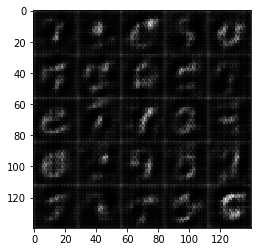

Epoch 1/2.	 Discriminator Loss: 1.1432;  Generator Loss: 0.7523
Epoch 1/2.	 Discriminator Loss: 0.9954;  Generator Loss: 1.1054
Epoch 1/2.	 Discriminator Loss: 2.1476;  Generator Loss: 3.3757
Epoch 1/2.	 Discriminator Loss: 1.2546;  Generator Loss: 1.5275
Epoch 1/2.	 Discriminator Loss: 1.2935;  Generator Loss: 0.6038
Epoch 1/2.	 Discriminator Loss: 1.1396;  Generator Loss: 0.9037
Epoch 1/2.	 Discriminator Loss: 1.4214;  Generator Loss: 2.2666
Epoch 1/2.	 Discriminator Loss: 1.0459;  Generator Loss: 1.4513
Epoch 1/2.	 Discriminator Loss: 1.4125;  Generator Loss: 0.5186
Epoch 1/2.	 Discriminator Loss: 1.3942;  Generator Loss: 0.5494


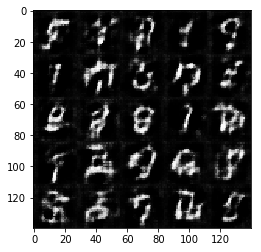

Epoch 1/2.	 Discriminator Loss: 1.1618;  Generator Loss: 0.6858
Epoch 1/2.	 Discriminator Loss: 1.0698;  Generator Loss: 0.9425
Epoch 1/2.	 Discriminator Loss: 1.1619;  Generator Loss: 1.7869
Epoch 1/2.	 Discriminator Loss: 1.3651;  Generator Loss: 0.5410
Epoch 1/2.	 Discriminator Loss: 1.0234;  Generator Loss: 1.2219
Epoch 1/2.	 Discriminator Loss: 1.3820;  Generator Loss: 0.5097
Epoch 1/2.	 Discriminator Loss: 1.2293;  Generator Loss: 1.8394
Epoch 1/2.	 Discriminator Loss: 1.3950;  Generator Loss: 0.4951
Epoch 1/2.	 Discriminator Loss: 1.0534;  Generator Loss: 0.9835
Epoch 1/2.	 Discriminator Loss: 1.1633;  Generator Loss: 0.6905


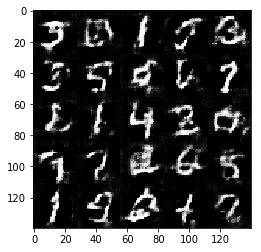

Epoch 1/2.	 Discriminator Loss: 1.6365;  Generator Loss: 0.3765
Epoch 1/2.	 Discriminator Loss: 0.9165;  Generator Loss: 1.6830
Epoch 1/2.	 Discriminator Loss: 0.9207;  Generator Loss: 1.4602
Epoch 1/2.	 Discriminator Loss: 0.9621;  Generator Loss: 1.1253
Epoch 1/2.	 Discriminator Loss: 1.2164;  Generator Loss: 0.8353
Epoch 1/2.	 Discriminator Loss: 0.9754;  Generator Loss: 1.1004
Epoch 1/2.	 Discriminator Loss: 1.2868;  Generator Loss: 0.5585
Epoch 1/2.	 Discriminator Loss: 1.0977;  Generator Loss: 1.5083
Epoch 1/2.	 Discriminator Loss: 0.9212;  Generator Loss: 1.8049
Epoch 1/2.	 Discriminator Loss: 1.4270;  Generator Loss: 0.5027


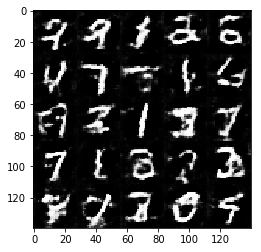

Epoch 1/2.	 Discriminator Loss: 1.7953;  Generator Loss: 0.3619
Epoch 1/2.	 Discriminator Loss: 1.1099;  Generator Loss: 0.8074
Epoch 1/2.	 Discriminator Loss: 1.0620;  Generator Loss: 1.1374
Epoch 1/2.	 Discriminator Loss: 1.0703;  Generator Loss: 1.4306
Epoch 1/2.	 Discriminator Loss: 1.0366;  Generator Loss: 1.1966
Epoch 1/2.	 Discriminator Loss: 1.0169;  Generator Loss: 1.5923
Epoch 1/2.	 Discriminator Loss: 1.2520;  Generator Loss: 0.6706
Epoch 1/2.	 Discriminator Loss: 1.2154;  Generator Loss: 0.6435
Epoch 1/2.	 Discriminator Loss: 1.5786;  Generator Loss: 0.4191
Epoch 1/2.	 Discriminator Loss: 1.0441;  Generator Loss: 1.8662


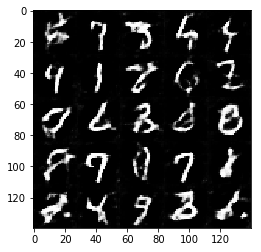

Epoch 1/2.	 Discriminator Loss: 0.9596;  Generator Loss: 1.2207
Epoch 1/2.	 Discriminator Loss: 0.9698;  Generator Loss: 1.0174
Epoch 1/2.	 Discriminator Loss: 2.5559;  Generator Loss: 3.5913
Epoch 1/2.	 Discriminator Loss: 1.0651;  Generator Loss: 1.1653
Epoch 1/2.	 Discriminator Loss: 1.3101;  Generator Loss: 0.5945
Epoch 1/2.	 Discriminator Loss: 1.5917;  Generator Loss: 0.4233
Epoch 1/2.	 Discriminator Loss: 0.8648;  Generator Loss: 1.6953
Epoch 1/2.	 Discriminator Loss: 1.0203;  Generator Loss: 0.9486
Epoch 1/2.	 Discriminator Loss: 0.9766;  Generator Loss: 2.2398
Epoch 1/2.	 Discriminator Loss: 0.8359;  Generator Loss: 1.3319


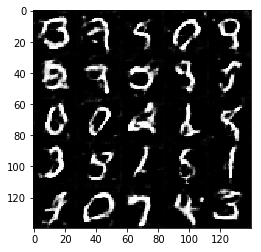

Epoch 1/2.	 Discriminator Loss: 0.9578;  Generator Loss: 1.0494
Epoch 1/2.	 Discriminator Loss: 1.0552;  Generator Loss: 0.8484
Epoch 1/2.	 Discriminator Loss: 0.9184;  Generator Loss: 1.0661
Epoch 1/2.	 Discriminator Loss: 1.0137;  Generator Loss: 0.9466
Epoch 1/2.	 Discriminator Loss: 0.7747;  Generator Loss: 1.5571
Epoch 1/2.	 Discriminator Loss: 1.0380;  Generator Loss: 1.2717
Epoch 1/2.	 Discriminator Loss: 1.2000;  Generator Loss: 0.6688
Epoch 1/2.	 Discriminator Loss: 1.0325;  Generator Loss: 0.9202
Epoch 1/2.	 Discriminator Loss: 0.8760;  Generator Loss: 1.1255
Epoch 1/2.	 Discriminator Loss: 1.3307;  Generator Loss: 0.7218


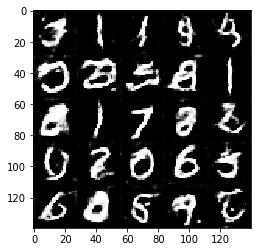

Epoch 1/2.	 Discriminator Loss: 1.0331;  Generator Loss: 0.9002
Epoch 1/2.	 Discriminator Loss: 1.2924;  Generator Loss: 2.9359
Epoch 1/2.	 Discriminator Loss: 0.8311;  Generator Loss: 1.5935
Epoch 1/2.	 Discriminator Loss: 0.9613;  Generator Loss: 1.0862
Epoch 1/2.	 Discriminator Loss: 1.6035;  Generator Loss: 0.4809
Epoch 1/2.	 Discriminator Loss: 1.4973;  Generator Loss: 0.5236
Epoch 1/2.	 Discriminator Loss: 1.0551;  Generator Loss: 1.8124
Epoch 1/2.	 Discriminator Loss: 0.9609;  Generator Loss: 1.0854
Epoch 1/2.	 Discriminator Loss: 1.7038;  Generator Loss: 0.4022
Epoch 1/2.	 Discriminator Loss: 1.0892;  Generator Loss: 1.3474


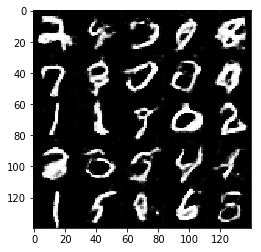

Epoch 1/2.	 Discriminator Loss: 1.2430;  Generator Loss: 1.8914
Epoch 1/2.	 Discriminator Loss: 0.9970;  Generator Loss: 1.0859
Epoch 1/2.	 Discriminator Loss: 1.0723;  Generator Loss: 0.8623
Epoch 1/2.	 Discriminator Loss: 1.5357;  Generator Loss: 0.4871
Epoch 1/2.	 Discriminator Loss: 1.0784;  Generator Loss: 0.7844
Epoch 1/2.	 Discriminator Loss: 1.7774;  Generator Loss: 3.2005
Epoch 1/2.	 Discriminator Loss: 1.0104;  Generator Loss: 1.3029
Epoch 1/2.	 Discriminator Loss: 1.4362;  Generator Loss: 0.5307
Epoch 1/2.	 Discriminator Loss: 1.1437;  Generator Loss: 0.8279
Epoch 1/2.	 Discriminator Loss: 1.1164;  Generator Loss: 0.8616


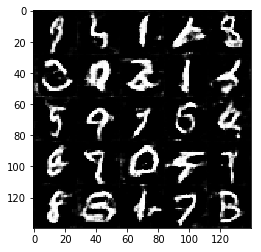

Epoch 1/2.	 Discriminator Loss: 0.9619;  Generator Loss: 1.0175
Epoch 1/2.	 Discriminator Loss: 1.3050;  Generator Loss: 0.6667
Epoch 1/2.	 Discriminator Loss: 1.0123;  Generator Loss: 1.6886
Epoch 2/2.	 Discriminator Loss: 0.9976;  Generator Loss: 0.9965
Epoch 2/2.	 Discriminator Loss: 1.2439;  Generator Loss: 0.6656
Epoch 2/2.	 Discriminator Loss: 0.8724;  Generator Loss: 1.4635
Epoch 2/2.	 Discriminator Loss: 0.9914;  Generator Loss: 0.9563
Epoch 2/2.	 Discriminator Loss: 1.1382;  Generator Loss: 0.7509
Epoch 2/2.	 Discriminator Loss: 0.7463;  Generator Loss: 1.2854
Epoch 2/2.	 Discriminator Loss: 0.7099;  Generator Loss: 1.4037


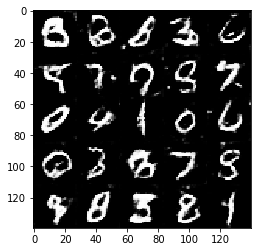

Epoch 2/2.	 Discriminator Loss: 0.8168;  Generator Loss: 2.1770
Epoch 2/2.	 Discriminator Loss: 1.0231;  Generator Loss: 0.9443
Epoch 2/2.	 Discriminator Loss: 0.9014;  Generator Loss: 1.2510
Epoch 2/2.	 Discriminator Loss: 0.7803;  Generator Loss: 1.3693
Epoch 2/2.	 Discriminator Loss: 1.2670;  Generator Loss: 0.8231
Epoch 2/2.	 Discriminator Loss: 0.8245;  Generator Loss: 1.2627
Epoch 2/2.	 Discriminator Loss: 0.7056;  Generator Loss: 1.4309
Epoch 2/2.	 Discriminator Loss: 0.6551;  Generator Loss: 1.5897
Epoch 2/2.	 Discriminator Loss: 1.1374;  Generator Loss: 0.7944
Epoch 2/2.	 Discriminator Loss: 0.9494;  Generator Loss: 1.2510


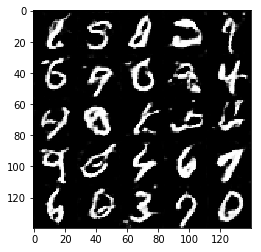

Epoch 2/2.	 Discriminator Loss: 0.9246;  Generator Loss: 1.3989
Epoch 2/2.	 Discriminator Loss: 0.8866;  Generator Loss: 1.1618
Epoch 2/2.	 Discriminator Loss: 0.9817;  Generator Loss: 1.8227
Epoch 2/2.	 Discriminator Loss: 0.7250;  Generator Loss: 1.7175
Epoch 2/2.	 Discriminator Loss: 1.1540;  Generator Loss: 0.7679
Epoch 2/2.	 Discriminator Loss: 0.8670;  Generator Loss: 1.1279
Epoch 2/2.	 Discriminator Loss: 0.7898;  Generator Loss: 1.5584
Epoch 2/2.	 Discriminator Loss: 0.8970;  Generator Loss: 1.1803
Epoch 2/2.	 Discriminator Loss: 1.4755;  Generator Loss: 0.5896
Epoch 2/2.	 Discriminator Loss: 1.0161;  Generator Loss: 1.4680


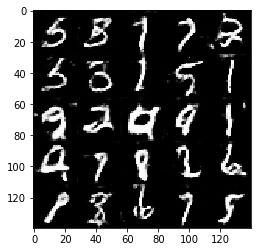

Epoch 2/2.	 Discriminator Loss: 1.0261;  Generator Loss: 0.8595
Epoch 2/2.	 Discriminator Loss: 0.9561;  Generator Loss: 1.1132
Epoch 2/2.	 Discriminator Loss: 1.3663;  Generator Loss: 0.6522
Epoch 2/2.	 Discriminator Loss: 0.8958;  Generator Loss: 1.1410
Epoch 2/2.	 Discriminator Loss: 0.9517;  Generator Loss: 1.0609
Epoch 2/2.	 Discriminator Loss: 0.8528;  Generator Loss: 1.6602
Epoch 2/2.	 Discriminator Loss: 1.5037;  Generator Loss: 0.4971
Epoch 2/2.	 Discriminator Loss: 0.8011;  Generator Loss: 1.3598
Epoch 2/2.	 Discriminator Loss: 1.1021;  Generator Loss: 0.8502
Epoch 2/2.	 Discriminator Loss: 1.3748;  Generator Loss: 0.5993


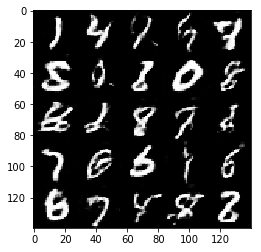

Epoch 2/2.	 Discriminator Loss: 2.3976;  Generator Loss: 0.2271
Epoch 2/2.	 Discriminator Loss: 1.0263;  Generator Loss: 0.9164
Epoch 2/2.	 Discriminator Loss: 0.8511;  Generator Loss: 1.2391
Epoch 2/2.	 Discriminator Loss: 0.9575;  Generator Loss: 1.0312
Epoch 2/2.	 Discriminator Loss: 1.0841;  Generator Loss: 3.2062
Epoch 2/2.	 Discriminator Loss: 0.8769;  Generator Loss: 1.7709
Epoch 2/2.	 Discriminator Loss: 0.7639;  Generator Loss: 1.4519
Epoch 2/2.	 Discriminator Loss: 0.7979;  Generator Loss: 1.7451
Epoch 2/2.	 Discriminator Loss: 0.6686;  Generator Loss: 1.7145
Epoch 2/2.	 Discriminator Loss: 1.2041;  Generator Loss: 0.7090


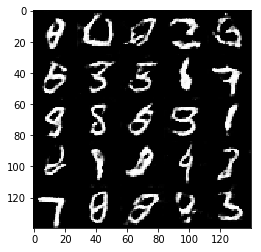

Epoch 2/2.	 Discriminator Loss: 0.9978;  Generator Loss: 2.5006
Epoch 2/2.	 Discriminator Loss: 0.8109;  Generator Loss: 3.1064
Epoch 2/2.	 Discriminator Loss: 0.7169;  Generator Loss: 1.4243
Epoch 2/2.	 Discriminator Loss: 0.8370;  Generator Loss: 1.2375
Epoch 2/2.	 Discriminator Loss: 0.7912;  Generator Loss: 1.3086
Epoch 2/2.	 Discriminator Loss: 1.0040;  Generator Loss: 0.9527
Epoch 2/2.	 Discriminator Loss: 0.8862;  Generator Loss: 1.2429
Epoch 2/2.	 Discriminator Loss: 1.5008;  Generator Loss: 0.5554
Epoch 2/2.	 Discriminator Loss: 0.7489;  Generator Loss: 1.3477
Epoch 2/2.	 Discriminator Loss: 0.6217;  Generator Loss: 1.8527


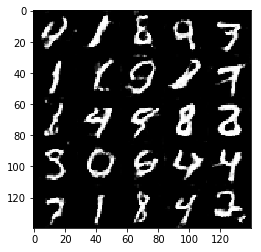

Epoch 2/2.	 Discriminator Loss: 0.7621;  Generator Loss: 1.5652
Epoch 2/2.	 Discriminator Loss: 0.6374;  Generator Loss: 1.8008
Epoch 2/2.	 Discriminator Loss: 1.0636;  Generator Loss: 1.6364
Epoch 2/2.	 Discriminator Loss: 0.8365;  Generator Loss: 1.4469
Epoch 2/2.	 Discriminator Loss: 0.7877;  Generator Loss: 1.5764
Epoch 2/2.	 Discriminator Loss: 0.9794;  Generator Loss: 2.0731
Epoch 2/2.	 Discriminator Loss: 0.7192;  Generator Loss: 1.6600
Epoch 2/2.	 Discriminator Loss: 1.1316;  Generator Loss: 0.8222
Epoch 2/2.	 Discriminator Loss: 1.0185;  Generator Loss: 0.9524
Epoch 2/2.	 Discriminator Loss: 1.0422;  Generator Loss: 0.8998


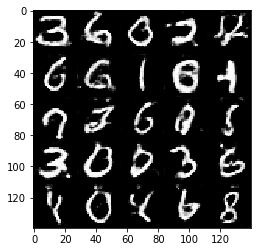

Epoch 2/2.	 Discriminator Loss: 0.9343;  Generator Loss: 1.1629
Epoch 2/2.	 Discriminator Loss: 1.0157;  Generator Loss: 0.9625
Epoch 2/2.	 Discriminator Loss: 1.0267;  Generator Loss: 0.9210
Epoch 2/2.	 Discriminator Loss: 0.9300;  Generator Loss: 2.4677
Epoch 2/2.	 Discriminator Loss: 0.8627;  Generator Loss: 1.2826
Epoch 2/2.	 Discriminator Loss: 1.4421;  Generator Loss: 0.5593
Epoch 2/2.	 Discriminator Loss: 1.1860;  Generator Loss: 0.8024
Epoch 2/2.	 Discriminator Loss: 0.7490;  Generator Loss: 1.9717
Epoch 2/2.	 Discriminator Loss: 2.2692;  Generator Loss: 0.3272
Epoch 2/2.	 Discriminator Loss: 0.8604;  Generator Loss: 1.1460


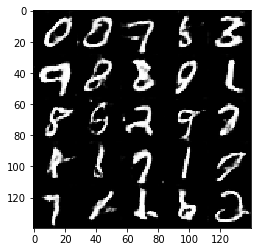

Epoch 2/2.	 Discriminator Loss: 0.9711;  Generator Loss: 1.0124
Epoch 2/2.	 Discriminator Loss: 0.7221;  Generator Loss: 1.4187
Epoch 2/2.	 Discriminator Loss: 1.1127;  Generator Loss: 0.8907
Epoch 2/2.	 Discriminator Loss: 1.0701;  Generator Loss: 0.8007
Epoch 2/2.	 Discriminator Loss: 1.3599;  Generator Loss: 1.1238
Epoch 2/2.	 Discriminator Loss: 1.0126;  Generator Loss: 0.9356
Epoch 2/2.	 Discriminator Loss: 0.9282;  Generator Loss: 1.1966
Epoch 2/2.	 Discriminator Loss: 0.9244;  Generator Loss: 1.0227
Epoch 2/2.	 Discriminator Loss: 0.7670;  Generator Loss: 1.3707
Epoch 2/2.	 Discriminator Loss: 1.9093;  Generator Loss: 0.3594


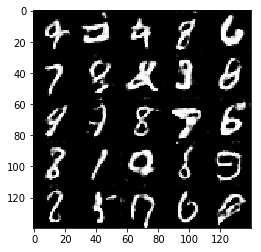

Epoch 2/2.	 Discriminator Loss: 0.8227;  Generator Loss: 1.2714
Epoch 2/2.	 Discriminator Loss: 2.1616;  Generator Loss: 0.3389
Epoch 2/2.	 Discriminator Loss: 1.1849;  Generator Loss: 0.7222
Epoch 2/2.	 Discriminator Loss: 0.8777;  Generator Loss: 1.2778
Epoch 2/2.	 Discriminator Loss: 0.6579;  Generator Loss: 1.6335
Epoch 2/2.	 Discriminator Loss: 2.1415;  Generator Loss: 0.4413
Epoch 2/2.	 Discriminator Loss: 0.9614;  Generator Loss: 1.0228


In [49]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1.	 Discriminator Loss: 1.2973;  Generator Loss: 1.7730
Epoch 1/1.	 Discriminator Loss: 0.8142;  Generator Loss: 1.5611
Epoch 1/1.	 Discriminator Loss: 3.0128;  Generator Loss: 0.1585
Epoch 1/1.	 Discriminator Loss: 1.3344;  Generator Loss: 0.6329
Epoch 1/1.	 Discriminator Loss: 1.7413;  Generator Loss: 0.4307
Epoch 1/1.	 Discriminator Loss: 1.0648;  Generator Loss: 0.9806
Epoch 1/1.	 Discriminator Loss: 1.1772;  Generator Loss: 0.9407
Epoch 1/1.	 Discriminator Loss: 1.1859;  Generator Loss: 1.2803
Epoch 1/1.	 Discriminator Loss: 0.7058;  Generator Loss: 1.8941
Epoch 1/1.	 Discriminator Loss: 1.0639;  Generator Loss: 1.3239


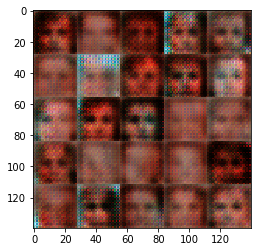

Epoch 1/1.	 Discriminator Loss: 2.1830;  Generator Loss: 3.2131
Epoch 1/1.	 Discriminator Loss: 1.4212;  Generator Loss: 0.5558
Epoch 1/1.	 Discriminator Loss: 1.3510;  Generator Loss: 1.1558
Epoch 1/1.	 Discriminator Loss: 1.5511;  Generator Loss: 0.9522
Epoch 1/1.	 Discriminator Loss: 1.0456;  Generator Loss: 0.9013
Epoch 1/1.	 Discriminator Loss: 1.3487;  Generator Loss: 0.8343
Epoch 1/1.	 Discriminator Loss: 1.0575;  Generator Loss: 1.5436
Epoch 1/1.	 Discriminator Loss: 1.0736;  Generator Loss: 1.3877
Epoch 1/1.	 Discriminator Loss: 0.5945;  Generator Loss: 1.8353
Epoch 1/1.	 Discriminator Loss: 1.8086;  Generator Loss: 0.5295


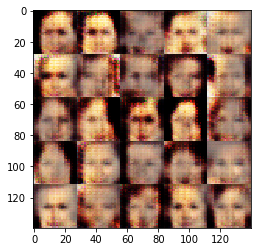

Epoch 1/1.	 Discriminator Loss: 1.2564;  Generator Loss: 0.8806
Epoch 1/1.	 Discriminator Loss: 1.4377;  Generator Loss: 0.7012
Epoch 1/1.	 Discriminator Loss: 1.3496;  Generator Loss: 1.1931
Epoch 1/1.	 Discriminator Loss: 1.3913;  Generator Loss: 1.6655
Epoch 1/1.	 Discriminator Loss: 1.9310;  Generator Loss: 2.4011
Epoch 1/1.	 Discriminator Loss: 1.1083;  Generator Loss: 0.7893
Epoch 1/1.	 Discriminator Loss: 1.5082;  Generator Loss: 0.6131
Epoch 1/1.	 Discriminator Loss: 0.6489;  Generator Loss: 1.7226
Epoch 1/1.	 Discriminator Loss: 3.2948;  Generator Loss: 0.0621
Epoch 1/1.	 Discriminator Loss: 1.4944;  Generator Loss: 0.7639


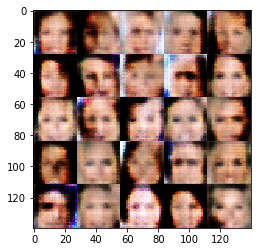

Epoch 1/1.	 Discriminator Loss: 1.4349;  Generator Loss: 0.5705
Epoch 1/1.	 Discriminator Loss: 1.3345;  Generator Loss: 0.5652
Epoch 1/1.	 Discriminator Loss: 1.4415;  Generator Loss: 1.0663
Epoch 1/1.	 Discriminator Loss: 1.7058;  Generator Loss: 0.7148
Epoch 1/1.	 Discriminator Loss: 1.0540;  Generator Loss: 0.9423
Epoch 1/1.	 Discriminator Loss: 1.4879;  Generator Loss: 0.4273
Epoch 1/1.	 Discriminator Loss: 1.6938;  Generator Loss: 1.9321
Epoch 1/1.	 Discriminator Loss: 1.2033;  Generator Loss: 0.7593
Epoch 1/1.	 Discriminator Loss: 1.1882;  Generator Loss: 0.7573
Epoch 1/1.	 Discriminator Loss: 1.1923;  Generator Loss: 0.9567


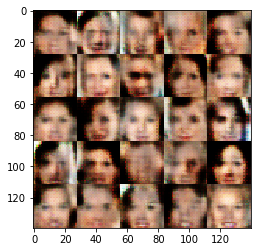

Epoch 1/1.	 Discriminator Loss: 1.2279;  Generator Loss: 0.8845
Epoch 1/1.	 Discriminator Loss: 1.1978;  Generator Loss: 0.8578
Epoch 1/1.	 Discriminator Loss: 1.1680;  Generator Loss: 0.6122
Epoch 1/1.	 Discriminator Loss: 1.4624;  Generator Loss: 0.5009
Epoch 1/1.	 Discriminator Loss: 1.9308;  Generator Loss: 0.3007
Epoch 1/1.	 Discriminator Loss: 1.2729;  Generator Loss: 0.9312
Epoch 1/1.	 Discriminator Loss: 1.1795;  Generator Loss: 0.7201
Epoch 1/1.	 Discriminator Loss: 1.2662;  Generator Loss: 1.1620
Epoch 1/1.	 Discriminator Loss: 1.2782;  Generator Loss: 0.9992
Epoch 1/1.	 Discriminator Loss: 1.2979;  Generator Loss: 0.8758


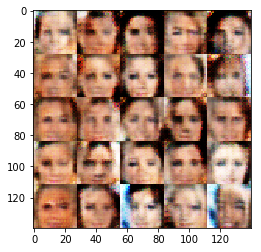

Epoch 1/1.	 Discriminator Loss: 1.0849;  Generator Loss: 0.7931
Epoch 1/1.	 Discriminator Loss: 1.4008;  Generator Loss: 0.7190
Epoch 1/1.	 Discriminator Loss: 1.2271;  Generator Loss: 0.8192
Epoch 1/1.	 Discriminator Loss: 1.1203;  Generator Loss: 1.0615
Epoch 1/1.	 Discriminator Loss: 1.2201;  Generator Loss: 1.1777
Epoch 1/1.	 Discriminator Loss: 1.2084;  Generator Loss: 1.0480
Epoch 1/1.	 Discriminator Loss: 1.3473;  Generator Loss: 0.9803
Epoch 1/1.	 Discriminator Loss: 1.3039;  Generator Loss: 0.8022
Epoch 1/1.	 Discriminator Loss: 1.3916;  Generator Loss: 0.7295
Epoch 1/1.	 Discriminator Loss: 1.3086;  Generator Loss: 1.0115


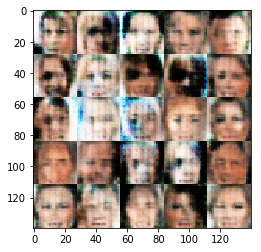

Epoch 1/1.	 Discriminator Loss: 1.3204;  Generator Loss: 1.1576
Epoch 1/1.	 Discriminator Loss: 1.3822;  Generator Loss: 1.1488
Epoch 1/1.	 Discriminator Loss: 1.2398;  Generator Loss: 0.5496
Epoch 1/1.	 Discriminator Loss: 1.5063;  Generator Loss: 1.5525
Epoch 1/1.	 Discriminator Loss: 1.3957;  Generator Loss: 0.5226
Epoch 1/1.	 Discriminator Loss: 1.1746;  Generator Loss: 0.6944
Epoch 1/1.	 Discriminator Loss: 1.3445;  Generator Loss: 0.6730
Epoch 1/1.	 Discriminator Loss: 1.4512;  Generator Loss: 0.6367
Epoch 1/1.	 Discriminator Loss: 2.0730;  Generator Loss: 1.4210
Epoch 1/1.	 Discriminator Loss: 1.3021;  Generator Loss: 1.0585


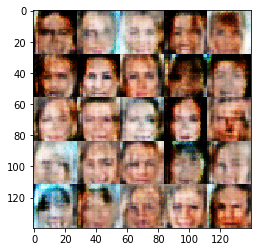

Epoch 1/1.	 Discriminator Loss: 1.2306;  Generator Loss: 0.8367
Epoch 1/1.	 Discriminator Loss: 1.3957;  Generator Loss: 0.5397
Epoch 1/1.	 Discriminator Loss: 1.0914;  Generator Loss: 0.8727
Epoch 1/1.	 Discriminator Loss: 1.3358;  Generator Loss: 0.7575
Epoch 1/1.	 Discriminator Loss: 1.3313;  Generator Loss: 1.0031
Epoch 1/1.	 Discriminator Loss: 1.1607;  Generator Loss: 0.9972
Epoch 1/1.	 Discriminator Loss: 0.9980;  Generator Loss: 0.7534
Epoch 1/1.	 Discriminator Loss: 1.2721;  Generator Loss: 1.3018
Epoch 1/1.	 Discriminator Loss: 1.1145;  Generator Loss: 0.8476
Epoch 1/1.	 Discriminator Loss: 1.5013;  Generator Loss: 0.6752


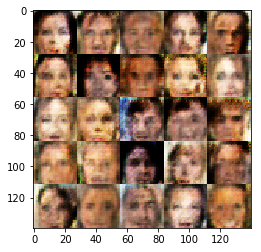

Epoch 1/1.	 Discriminator Loss: 1.4104;  Generator Loss: 1.2663
Epoch 1/1.	 Discriminator Loss: 1.1669;  Generator Loss: 0.8098
Epoch 1/1.	 Discriminator Loss: 1.2864;  Generator Loss: 0.7990
Epoch 1/1.	 Discriminator Loss: 1.3187;  Generator Loss: 0.7545
Epoch 1/1.	 Discriminator Loss: 1.4401;  Generator Loss: 0.7453
Epoch 1/1.	 Discriminator Loss: 1.8094;  Generator Loss: 0.3081
Epoch 1/1.	 Discriminator Loss: 1.5425;  Generator Loss: 0.8230
Epoch 1/1.	 Discriminator Loss: 1.3504;  Generator Loss: 0.8646
Epoch 1/1.	 Discriminator Loss: 1.2865;  Generator Loss: 0.5854
Epoch 1/1.	 Discriminator Loss: 1.4842;  Generator Loss: 0.8832


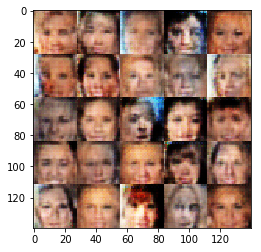

Epoch 1/1.	 Discriminator Loss: 1.2835;  Generator Loss: 0.9951
Epoch 1/1.	 Discriminator Loss: 1.5469;  Generator Loss: 1.2296
Epoch 1/1.	 Discriminator Loss: 1.2825;  Generator Loss: 0.8426
Epoch 1/1.	 Discriminator Loss: 1.1859;  Generator Loss: 0.7552
Epoch 1/1.	 Discriminator Loss: 1.1678;  Generator Loss: 0.7423
Epoch 1/1.	 Discriminator Loss: 1.4142;  Generator Loss: 0.8791
Epoch 1/1.	 Discriminator Loss: 1.3295;  Generator Loss: 1.2653
Epoch 1/1.	 Discriminator Loss: 1.1518;  Generator Loss: 0.8909
Epoch 1/1.	 Discriminator Loss: 1.2422;  Generator Loss: 0.6653
Epoch 1/1.	 Discriminator Loss: 1.2349;  Generator Loss: 0.9012


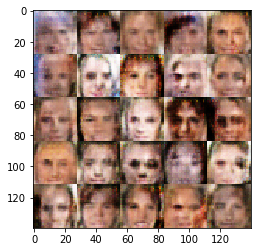

Epoch 1/1.	 Discriminator Loss: 1.2398;  Generator Loss: 0.9990
Epoch 1/1.	 Discriminator Loss: 1.2731;  Generator Loss: 0.7799
Epoch 1/1.	 Discriminator Loss: 1.3017;  Generator Loss: 1.0388
Epoch 1/1.	 Discriminator Loss: 1.2097;  Generator Loss: 0.5729
Epoch 1/1.	 Discriminator Loss: 1.2828;  Generator Loss: 0.5542
Epoch 1/1.	 Discriminator Loss: 1.4134;  Generator Loss: 0.5210
Epoch 1/1.	 Discriminator Loss: 1.6357;  Generator Loss: 0.5927
Epoch 1/1.	 Discriminator Loss: 1.3654;  Generator Loss: 0.6498
Epoch 1/1.	 Discriminator Loss: 1.3249;  Generator Loss: 0.7138
Epoch 1/1.	 Discriminator Loss: 1.2522;  Generator Loss: 0.8665


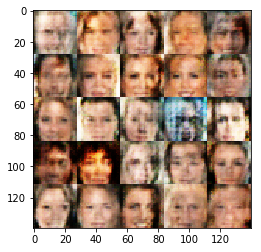

Epoch 1/1.	 Discriminator Loss: 1.2790;  Generator Loss: 0.9534
Epoch 1/1.	 Discriminator Loss: 1.4701;  Generator Loss: 0.8669
Epoch 1/1.	 Discriminator Loss: 1.2285;  Generator Loss: 0.8109
Epoch 1/1.	 Discriminator Loss: 1.4946;  Generator Loss: 0.9040
Epoch 1/1.	 Discriminator Loss: 1.1010;  Generator Loss: 0.8016
Epoch 1/1.	 Discriminator Loss: 1.2649;  Generator Loss: 0.9441
Epoch 1/1.	 Discriminator Loss: 1.4505;  Generator Loss: 0.8950
Epoch 1/1.	 Discriminator Loss: 1.3648;  Generator Loss: 0.7317
Epoch 1/1.	 Discriminator Loss: 1.3018;  Generator Loss: 0.7903
Epoch 1/1.	 Discriminator Loss: 1.3848;  Generator Loss: 0.8648


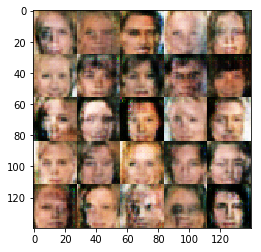

Epoch 1/1.	 Discriminator Loss: 1.1167;  Generator Loss: 0.7903
Epoch 1/1.	 Discriminator Loss: 1.5717;  Generator Loss: 0.5346
Epoch 1/1.	 Discriminator Loss: 1.3559;  Generator Loss: 0.9774
Epoch 1/1.	 Discriminator Loss: 1.5004;  Generator Loss: 0.8793
Epoch 1/1.	 Discriminator Loss: 1.4954;  Generator Loss: 0.5560
Epoch 1/1.	 Discriminator Loss: 1.2942;  Generator Loss: 0.9154
Epoch 1/1.	 Discriminator Loss: 1.3192;  Generator Loss: 0.7838
Epoch 1/1.	 Discriminator Loss: 1.2890;  Generator Loss: 1.2339
Epoch 1/1.	 Discriminator Loss: 1.2414;  Generator Loss: 0.6179
Epoch 1/1.	 Discriminator Loss: 1.3957;  Generator Loss: 1.1826


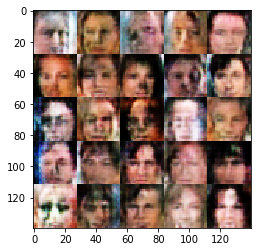

Epoch 1/1.	 Discriminator Loss: 1.4123;  Generator Loss: 0.5548
Epoch 1/1.	 Discriminator Loss: 1.3047;  Generator Loss: 1.0064
Epoch 1/1.	 Discriminator Loss: 1.2893;  Generator Loss: 0.6656
Epoch 1/1.	 Discriminator Loss: 1.2944;  Generator Loss: 0.5731
Epoch 1/1.	 Discriminator Loss: 1.1451;  Generator Loss: 0.8025
Epoch 1/1.	 Discriminator Loss: 1.1697;  Generator Loss: 1.0337
Epoch 1/1.	 Discriminator Loss: 1.2440;  Generator Loss: 0.7983
Epoch 1/1.	 Discriminator Loss: 1.3096;  Generator Loss: 0.7525
Epoch 1/1.	 Discriminator Loss: 1.4053;  Generator Loss: 0.5614
Epoch 1/1.	 Discriminator Loss: 1.3059;  Generator Loss: 0.7664


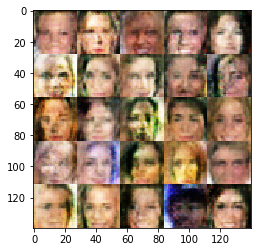

Epoch 1/1.	 Discriminator Loss: 1.3009;  Generator Loss: 1.0510
Epoch 1/1.	 Discriminator Loss: 1.0202;  Generator Loss: 0.8169
Epoch 1/1.	 Discriminator Loss: 1.2913;  Generator Loss: 0.7758
Epoch 1/1.	 Discriminator Loss: 1.2806;  Generator Loss: 0.8407
Epoch 1/1.	 Discriminator Loss: 1.2855;  Generator Loss: 0.7936
Epoch 1/1.	 Discriminator Loss: 1.0819;  Generator Loss: 0.7866
Epoch 1/1.	 Discriminator Loss: 1.0161;  Generator Loss: 0.8034
Epoch 1/1.	 Discriminator Loss: 1.3888;  Generator Loss: 0.7804
Epoch 1/1.	 Discriminator Loss: 1.4208;  Generator Loss: 0.7417
Epoch 1/1.	 Discriminator Loss: 1.2133;  Generator Loss: 0.7897


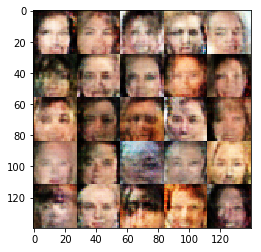

Epoch 1/1.	 Discriminator Loss: 1.3607;  Generator Loss: 0.8623
Epoch 1/1.	 Discriminator Loss: 1.2909;  Generator Loss: 0.9068
Epoch 1/1.	 Discriminator Loss: 1.3731;  Generator Loss: 1.2357
Epoch 1/1.	 Discriminator Loss: 1.6802;  Generator Loss: 0.4353
Epoch 1/1.	 Discriminator Loss: 1.2886;  Generator Loss: 0.8994
Epoch 1/1.	 Discriminator Loss: 1.4436;  Generator Loss: 0.8867
Epoch 1/1.	 Discriminator Loss: 1.0797;  Generator Loss: 0.9274
Epoch 1/1.	 Discriminator Loss: 1.2800;  Generator Loss: 1.0844
Epoch 1/1.	 Discriminator Loss: 1.3028;  Generator Loss: 0.7467
Epoch 1/1.	 Discriminator Loss: 1.3675;  Generator Loss: 0.9410


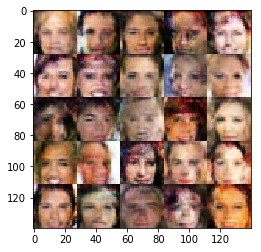

Epoch 1/1.	 Discriminator Loss: 1.2035;  Generator Loss: 0.8586
Epoch 1/1.	 Discriminator Loss: 1.2860;  Generator Loss: 0.8212
Epoch 1/1.	 Discriminator Loss: 1.3397;  Generator Loss: 0.6020
Epoch 1/1.	 Discriminator Loss: 1.3330;  Generator Loss: 0.7853
Epoch 1/1.	 Discriminator Loss: 1.4742;  Generator Loss: 0.8932
Epoch 1/1.	 Discriminator Loss: 1.3227;  Generator Loss: 0.7971
Epoch 1/1.	 Discriminator Loss: 1.3740;  Generator Loss: 0.6231
Epoch 1/1.	 Discriminator Loss: 1.2257;  Generator Loss: 0.8476
Epoch 1/1.	 Discriminator Loss: 1.3818;  Generator Loss: 0.8677
Epoch 1/1.	 Discriminator Loss: 1.3548;  Generator Loss: 0.8164


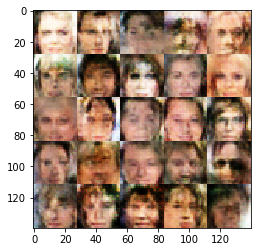

Epoch 1/1.	 Discriminator Loss: 1.2454;  Generator Loss: 0.8367
Epoch 1/1.	 Discriminator Loss: 1.3362;  Generator Loss: 0.9119
Epoch 1/1.	 Discriminator Loss: 1.2348;  Generator Loss: 1.0757
Epoch 1/1.	 Discriminator Loss: 1.3928;  Generator Loss: 0.6661
Epoch 1/1.	 Discriminator Loss: 1.2531;  Generator Loss: 0.7318
Epoch 1/1.	 Discriminator Loss: 1.1036;  Generator Loss: 0.7040
Epoch 1/1.	 Discriminator Loss: 1.2620;  Generator Loss: 0.9260
Epoch 1/1.	 Discriminator Loss: 1.3086;  Generator Loss: 0.7745
Epoch 1/1.	 Discriminator Loss: 1.3782;  Generator Loss: 1.0321
Epoch 1/1.	 Discriminator Loss: 1.0982;  Generator Loss: 0.7392


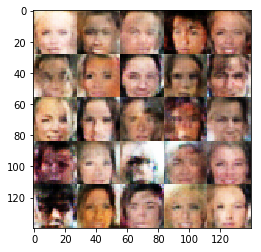

Epoch 1/1.	 Discriminator Loss: 1.4818;  Generator Loss: 0.7119
Epoch 1/1.	 Discriminator Loss: 1.0322;  Generator Loss: 0.8520
Epoch 1/1.	 Discriminator Loss: 1.3581;  Generator Loss: 0.9815
Epoch 1/1.	 Discriminator Loss: 1.2139;  Generator Loss: 0.7480
Epoch 1/1.	 Discriminator Loss: 1.3381;  Generator Loss: 0.9373
Epoch 1/1.	 Discriminator Loss: 1.4326;  Generator Loss: 0.9833
Epoch 1/1.	 Discriminator Loss: 1.2136;  Generator Loss: 0.8664
Epoch 1/1.	 Discriminator Loss: 1.3284;  Generator Loss: 1.1007
Epoch 1/1.	 Discriminator Loss: 1.1556;  Generator Loss: 1.0609
Epoch 1/1.	 Discriminator Loss: 1.1076;  Generator Loss: 1.0612


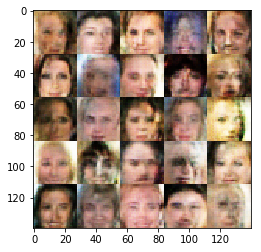

Epoch 1/1.	 Discriminator Loss: 1.2424;  Generator Loss: 0.8325
Epoch 1/1.	 Discriminator Loss: 1.2046;  Generator Loss: 0.9573
Epoch 1/1.	 Discriminator Loss: 1.2937;  Generator Loss: 1.0437
Epoch 1/1.	 Discriminator Loss: 1.5275;  Generator Loss: 0.4159
Epoch 1/1.	 Discriminator Loss: 1.5524;  Generator Loss: 0.8744
Epoch 1/1.	 Discriminator Loss: 1.4148;  Generator Loss: 0.7601
Epoch 1/1.	 Discriminator Loss: 1.2942;  Generator Loss: 0.8276
Epoch 1/1.	 Discriminator Loss: 1.0785;  Generator Loss: 0.8072
Epoch 1/1.	 Discriminator Loss: 1.2759;  Generator Loss: 0.7539
Epoch 1/1.	 Discriminator Loss: 1.1740;  Generator Loss: 0.8177


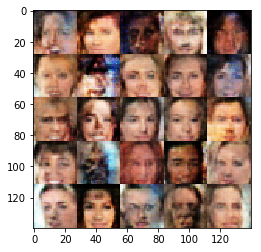

Epoch 1/1.	 Discriminator Loss: 1.2009;  Generator Loss: 0.8148
Epoch 1/1.	 Discriminator Loss: 1.6152;  Generator Loss: 0.4619


KeyboardInterrupt: 

In [50]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.